### Implementing Neural Network (Feed Forward) using Pytorch for MNIST Dataset

In [10]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [11]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

image.shape: torch.Size([1, 28, 28])
Label: 5


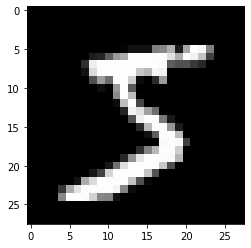

In [12]:
image, label = dataset[0]
image
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

In [13]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [14]:
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


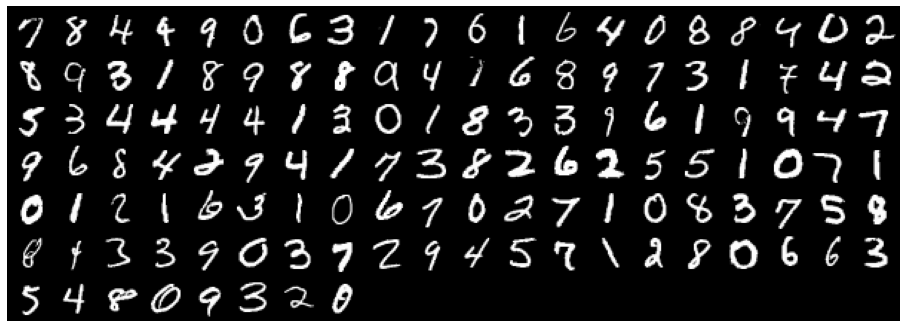

In [15]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=20).permute((1, 2, 0)))
    break

In [23]:
#Step 1 : Convert the Tensors into a Flat --> by reshaping the flat as 28*28=784
for images,labels in train_loader:
    print('input shape:',images.shape)
    inputs=images.reshape(-1,784)
    print('input shape:',inputs.shape)
    break

input shape: torch.Size([128, 1, 28, 28])
input shape: torch.Size([128, 784])


In [24]:
#for creating a feedforward Neural Net we need Input Size , Hidden Layer Size and Output Size
input_size=inputs.shape[-1]
hidden_layer_size=32
output_size=10

In [31]:
# First NN to Connect Input to Hidden
layer_1 = nn.Linear(input_size,hidden_layer_size)

In [32]:
inputs.shape

torch.Size([128, 784])

In [33]:
layer_1_outputs=layer_1(inputs)
layer_1_outputs.shape

torch.Size([128, 32])

In [36]:
layer_1.parameters

<bound method Module.parameters of Linear(in_features=784, out_features=32, bias=True)>

In [41]:
layer_1.weight #32 Weight Vectors with 784 inputs Values has Outfeatures as 32

Parameter containing:
tensor([[-0.0070, -0.0162,  0.0320,  ..., -0.0215,  0.0075,  0.0209],
        [ 0.0127, -0.0168,  0.0048,  ...,  0.0324,  0.0228, -0.0157],
        [ 0.0347, -0.0352, -0.0003,  ...,  0.0243, -0.0084,  0.0152],
        ...,
        [ 0.0196, -0.0134,  0.0297,  ..., -0.0176, -0.0245,  0.0045],
        [-0.0275,  0.0062,  0.0331,  ..., -0.0246, -0.0120,  0.0093],
        [ 0.0337,  0.0114,  0.0293,  ...,  0.0047,  0.0040, -0.0012]],
       requires_grad=True)

In [43]:
len(layer_1.weight[0]) 

784

In [39]:
layer_1.bias #32 Values has Outfeatures as 32

Parameter containing:
tensor([ 0.0104,  0.0138, -0.0059, -0.0063, -0.0067,  0.0353, -0.0357, -0.0148,
        -0.0350, -0.0049, -0.0020, -0.0299,  0.0208,  0.0134, -0.0205,  0.0196,
        -0.0211,  0.0024,  0.0304, -0.0078, -0.0210, -0.0137,  0.0353,  0.0051,
         0.0285, -0.0094, -0.0043, -0.0219,  0.0283, -0.0275,  0.0117, -0.0016],
       requires_grad=True)

In [44]:
layer1_outputs_direct = inputs @ layer_1.weight.t() + layer_1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

The image vectors of size 784 are transformed into intermediate output vectors of length 32 by performing a matrix multiplication of inputs matrix with the transposed weights matrix of layer1 and adding the bias

In [47]:
torch.allclose(layer_1_outputs, layer1_outputs_direct)

True

Thus, layer1_outputs and inputs have a linear relationship, i.e., each element of layer_outputs is a weighted sum of elements from inputs. Thus, even as we train the model and modify the weights, layer1 can only capture linear relationships between inputs and outputs.

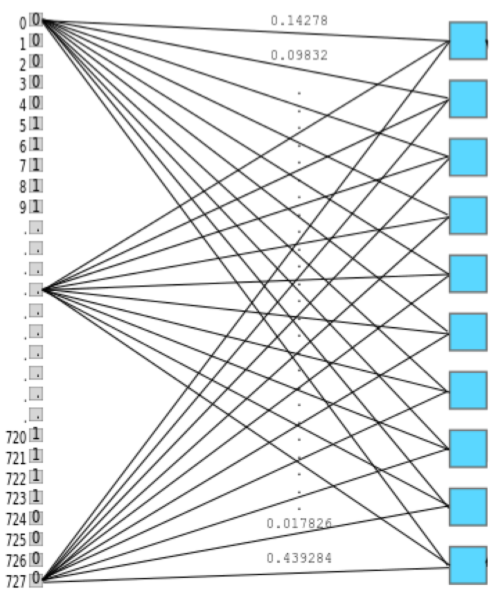

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula relu(x) = max(0,x) i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

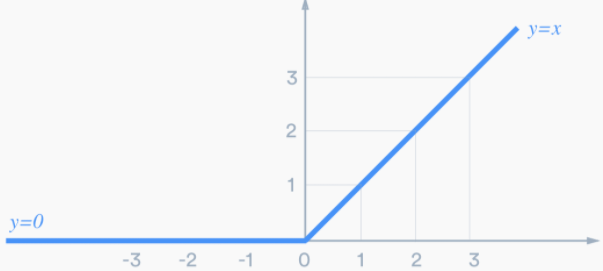

We can use the F.relu method to apply ReLU to the elements of a tensor.



##### Small Example to Understand Relu -> Rectified Linear Unit

In [48]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

As we see the Rele Non Linear Activation Funtion will make all the Values in Neagtive as 0, this deactivating the Neurons.

In [49]:
relu_outputs = F.relu(layer_1_outputs)
print('min(layer1_outputs):', torch.min(layer_1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.6643215417861938
min(relu_outputs): 0.0


In [51]:
# Second NN layer for Connecting the Hidden to Output layer
layer_2 = nn.Linear(hidden_layer_size, output_size)

In [52]:
layer_2_outputs=layer_2(relu_outputs) # Here the Input is the vector of Hidden Layer 
layer_2_outputs.shape

torch.Size([128, 10])

As expected, layer2_outputs contains a batch of vectors of size 10. We can now use this output to compute the loss using F.cross_entropy and adjust the weights of layer1 and layer2 using gradient descent.

In [53]:
F.cross_entropy(layer_2_outputs, labels)

tensor(2.3113, grad_fn=<NllLossBackward>)

Thus, our model transforms inputs into layer2_outputs by applying a linear transformation (using layer1), followed by a non-linear activation (using F.relu), followed by another linear transformation (using layer2). Let's verify this by re-computing the output using basic matrix operations.

In [55]:
outputs = (F.relu(inputs @ layer_1.weight.t() + layer_1.bias)) @ layer_2.weight.t() + layer_2.bias
layer2_outputs_direct.shape

torch.Size([128, 10])

In [56]:
torch.allclose(outputs, layer_2_outputs)

True

### Model
We are now ready to define our model. As discussed above, we'll create a neural network with one hidden layer. Here's what that means:

Instead of using a single nn.Linear object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two nn.Linear objects. Each of these is called a layer in the network.

The first layer (also known as the hidden layer) will transform the input matrix of shape batch_size x 784 into an intermediate output matrix of shape batch_size x hidden_size. The parameter hidden_size can be configured manually (e.g., 32 or 64).

We'll then apply a non-linear activation function to the intermediate outputs. The activation function transforms individual elements of the matrix.

The result of the activation function, which is also of size batch_size x hidden_size, is passed into the second layer (also known as the output layer). The second layer transforms it into a matrix of size batch_size x 10. We can use this output to compute the loss and adjust weights using gradient descent.

As discussed above, our model will contain one hidden layer. Here's what it looks like visually:

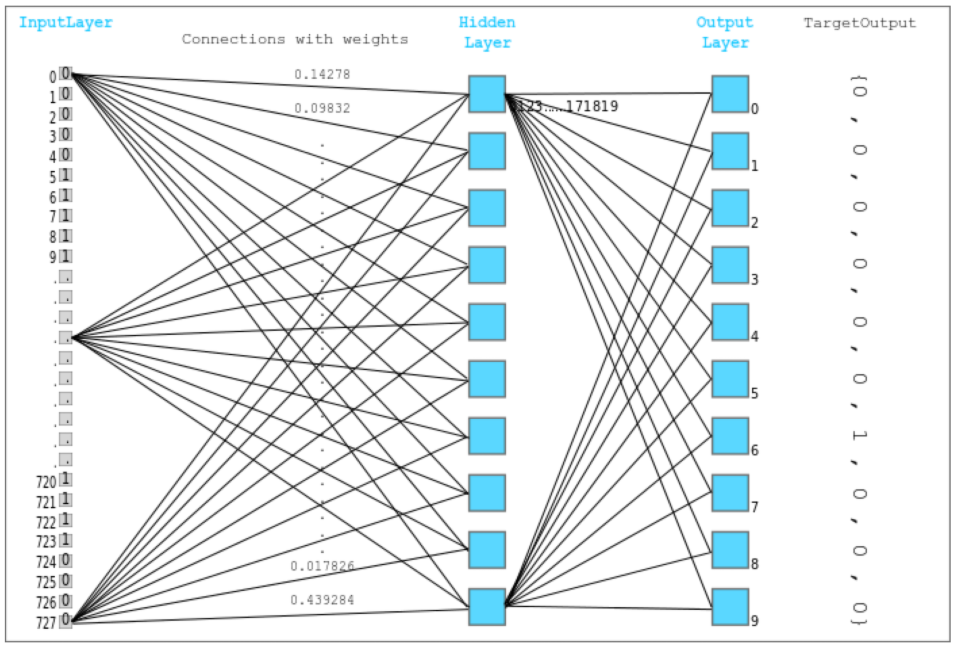

Let's define the model by extending the nn.Module class from PyTorch.

In [57]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [58]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [59]:
input_size = 784
hidden_size = 32 
num_classes = 10

In [60]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [62]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [63]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3311924934387207
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.2438,  0.0167,  0.0008, -0.1599, -0.0707,  0.0731,  0.0458, -0.1420,
         -0.1817,  0.1235],
        [ 0.2777, -0.0145,  0.0037, -0.1955, -0.0233,  0.0381,  0.0426, -0.1062,
         -0.1241,  0.0739]])


### Using a GPU

In [64]:
torch.cuda.is_available()

True

In [66]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [67]:
device = get_default_device()
device

device(type='cuda')

In [68]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [69]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


Finally, we define a DeviceDataLoader class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we don't need to extend an existing class to create a PyTorch datal oader. All we need is an __iter__ method to retrieve batches of data and an __len__ method to get the number of batches.

In [70]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [71]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [76]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([6, 5, 4, 3, 3, 5, 6, 0, 9, 2, 9, 5, 1, 3, 1, 2, 9, 9, 8, 6, 6, 4, 9, 3,
        2, 9, 3, 8, 7, 7, 9, 8, 1, 2, 4, 7, 8, 4, 2, 7, 9, 0, 7, 9, 3, 7, 9, 6,
        8, 3, 6, 5, 7, 8, 3, 2, 3, 7, 7, 4, 0, 1, 8, 9, 7, 1, 7, 0, 8, 5, 6, 8,
        6, 8, 5, 4, 2, 1, 5, 7, 4, 7, 1, 8, 2, 6, 3, 0, 7, 2, 4, 4, 4, 7, 4, 6,
        8, 4, 9, 6, 1, 4, 1, 4, 4, 4, 3, 4, 6, 0, 3, 6, 1, 6, 3, 1, 7, 7, 6, 7,
        0, 2, 1, 2, 9, 4, 0, 6, 3, 1, 4, 7, 2, 8, 9, 1, 5, 7, 8, 8, 8, 8, 4, 4,
        8, 8, 7, 7, 7, 6, 2, 9, 1, 6, 9, 9, 9, 5, 2, 6, 3, 7, 3, 8, 9, 6, 8, 7,
        6, 4, 6, 9, 9, 3, 4, 7, 9, 3, 7, 3, 0, 1, 4, 9, 7, 9, 2, 5, 1, 8, 8, 6,
        7, 2, 5, 5, 4, 2, 9, 5, 9, 4, 6, 6, 6, 2, 2, 5, 1, 0, 0, 6, 3, 6, 4, 2,
        8, 9, 1, 5, 9, 2, 5, 8, 5, 1, 1, 3, 3, 3, 7, 1, 0, 1, 0, 0, 4, 5, 9, 2,
        1, 9, 5, 0, 0, 1, 2, 4, 7, 8, 1, 5, 8, 2, 0, 7], device='cuda:0')


In [77]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [78]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [79]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.326265335083008, 'val_acc': 0.07548828423023224}]

In [80]:
history=fit(5, 0.5, model, train_loader, val_loader)
history

Epoch [0], val_loss: 0.2164, val_acc: 0.9360
Epoch [1], val_loss: 0.2121, val_acc: 0.9354
Epoch [2], val_loss: 0.1573, val_acc: 0.9519
Epoch [3], val_loss: 0.1624, val_acc: 0.9502
Epoch [4], val_loss: 0.1328, val_acc: 0.9610


[{'val_loss': 0.21635876595973969, 'val_acc': 0.93603515625},
 {'val_loss': 0.2120985984802246, 'val_acc': 0.935351550579071},
 {'val_loss': 0.1573447436094284, 'val_acc': 0.951855480670929},
 {'val_loss': 0.1623704731464386, 'val_acc': 0.9501953125},
 {'val_loss': 0.13281840085983276, 'val_acc': 0.9610351324081421}]

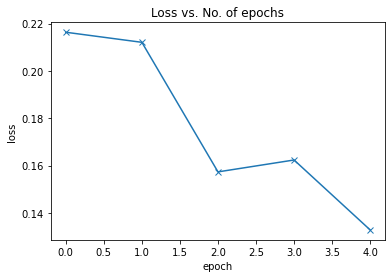

In [81]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

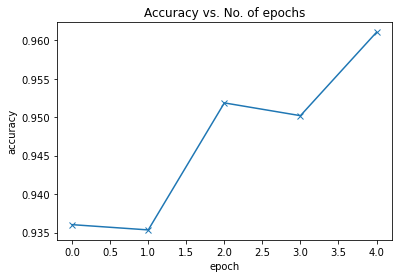

In [82]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

### Testing with individual images

In [83]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [84]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


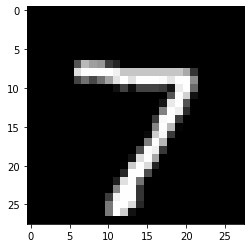

In [85]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 6 , Predicted: 6


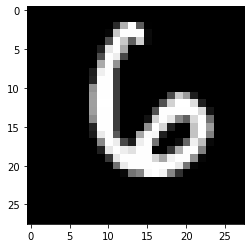

In [86]:
img, label = test_dataset[88]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 1 , Predicted: 1


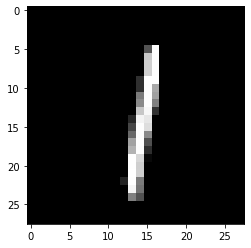

In [87]:
img, label = test_dataset[920]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 5 , Predicted: 6


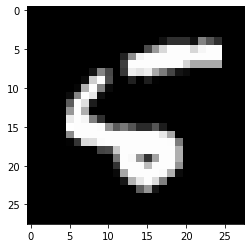

In [88]:
img, label = test_dataset[8]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 4 , Predicted: 4


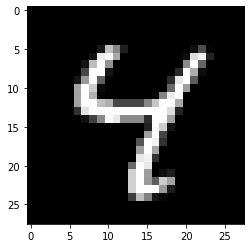

In [89]:
img, label = test_dataset[6]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))